In [1]:
if torch.cuda.is_available():
    tensor = tensor.to("cuda")

NameError: name 'torch' is not defined

In [2]:
from google.colab import files
uploaded = files.upload()


Saving BankChurners.csv to BankChurners.csv


In [4]:
import pandas as pd

df = pd.read_csv("BankChurners.csv")
df = df.drop(['CLIENTNUM', 'Attrition_Flag'], axis=1)  # 고객넘버, 플래그는 삭제
df.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [5]:
df_encoded = pd.get_dummies(df)
df_encoded.head()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,...,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
0,45,3,39,5,1,3,12691.0,777,11914.0,1.335,...,False,False,True,False,False,False,True,False,False,False
1,49,5,44,6,1,2,8256.0,864,7392.0,1.541,...,False,False,False,False,True,False,True,False,False,False
2,51,3,36,4,1,0,3418.0,0,3418.0,2.594,...,False,False,False,True,False,False,True,False,False,False
3,40,4,34,3,4,1,3313.0,2517,796.0,1.405,...,False,False,False,False,True,False,True,False,False,False
4,40,3,21,5,1,0,4716.0,0,4716.0,2.175,...,False,False,True,False,False,False,True,False,False,False


In [6]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(df_encoded)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [10]:
X = torch.tensor(data_scaled, dtype=torch.float32)
dataset = TensorDataset(X)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [11]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, latent_dim=2):
        super(VAE, self).__init__()

        # 인코더
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # 디코더
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

In [12]:
def loss_function(x, x_recon, mu, logvar):
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kld

In [13]:
input_dim = X.shape[1]
vae = VAE(input_dim)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 30

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x_batch = batch[0]
        x_recon, mu, logvar = vae(x_batch)

        loss = loss_function(x_batch, x_recon, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss:.2f}")

Epoch 1/30, Loss: 197488.55
Epoch 2/30, Loss: 171851.73
Epoch 3/30, Loss: 167374.55
Epoch 4/30, Loss: 165455.94
Epoch 5/30, Loss: 164325.82
Epoch 6/30, Loss: 163537.52
Epoch 7/30, Loss: 162665.43
Epoch 8/30, Loss: 162001.46
Epoch 9/30, Loss: 161468.10
Epoch 10/30, Loss: 160956.75
Epoch 11/30, Loss: 160379.06
Epoch 12/30, Loss: 160120.30
Epoch 13/30, Loss: 159749.30
Epoch 14/30, Loss: 159524.28
Epoch 15/30, Loss: 159505.08
Epoch 16/30, Loss: 159041.87
Epoch 17/30, Loss: 159261.85
Epoch 18/30, Loss: 158692.55
Epoch 19/30, Loss: 158597.10
Epoch 20/30, Loss: 158571.07
Epoch 21/30, Loss: 158155.02
Epoch 22/30, Loss: 158353.33
Epoch 23/30, Loss: 158236.73
Epoch 24/30, Loss: 158022.70
Epoch 25/30, Loss: 157920.66
Epoch 26/30, Loss: 158023.18
Epoch 27/30, Loss: 157798.51
Epoch 28/30, Loss: 157862.61
Epoch 29/30, Loss: 157701.30
Epoch 30/30, Loss: 157552.05


In [14]:
vae.eval()

with torch.no_grad():
    X_device = X.to(device)
    _, mu, _ = vae(X_device)
    latent = mu.cpu().numpy()

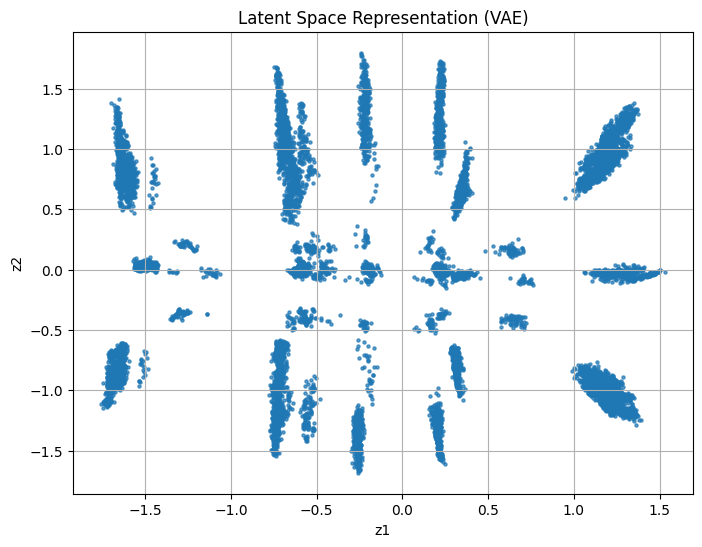

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(latent[:, 0], latent[:, 1], s=5, alpha=0.7)
plt.title("Latent Space Representation (VAE)")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.show()

In [16]:
from sklearn.cluster import KMeans

n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent)

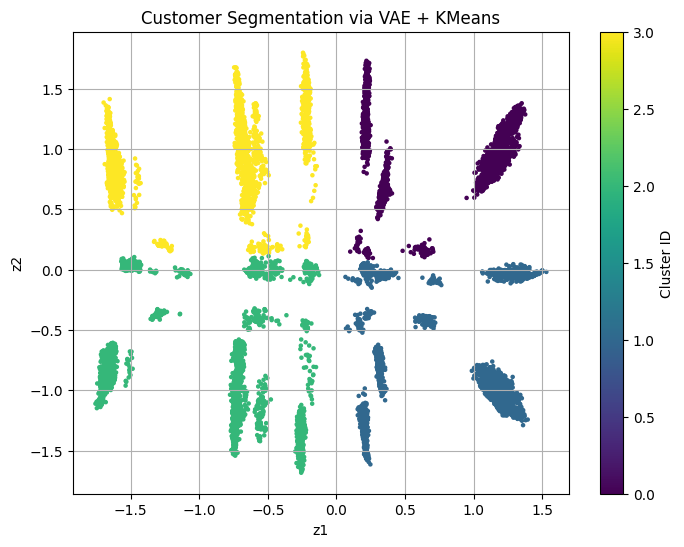

In [17]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(latent[:, 0], latent[:, 1], c=cluster_labels, cmap='viridis', s=5)
plt.title("Customer Segmentation via VAE + KMeans")
plt.xlabel("z1")
plt.ylabel("z2")
plt.grid(True)
plt.colorbar(scatter, label='Cluster ID')
plt.show()

In [18]:
df_clusters = df_encoded.copy()
df_clusters['Cluster'] = cluster_labels

In [31]:
cluster_summary = df_clusters.groupby('Cluster').mean(numeric_only=True)
pd.set_option('display.max_columns', None)
cluster_summary
#0,1이

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Gender_F,Gender_M,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,46.991024,2.343533,36.437373,3.837209,2.336597,2.387597,4646.474908,1145.574459,3500.900449,0.763949,4108.627499,63.667075,0.716400,0.353996,1.0,0.0,0.097511,0.051408,0.317421,0.195838,0.051408,0.139535,0.146879,0.000000,1.000000,0.000000,0.000000,0.000000,0.190126,0.000000,0.000000,0.613627,0.196246,0.964096,0.004080,0.000408,0.031416
1,46.006536,2.338149,35.592707,3.783282,2.364637,2.435501,5342.036877,1135.320605,4206.716271,0.746380,4506.175095,68.616443,0.711101,0.331805,1.0,0.0,0.100791,0.045064,0.306846,0.188510,0.047128,0.156175,0.155487,0.138287,0.000000,0.730994,0.130719,0.000000,0.188510,0.000000,0.000000,0.612315,0.199174,0.941864,0.009632,0.002752,0.045752
2,45.934096,2.318469,35.780189,3.793212,2.329124,2.474743,13443.447356,1131.177979,12312.269376,0.752662,4717.325178,66.357932,0.706972,0.182226,0.0,1.0,0.099842,0.045383,0.298737,0.203631,0.053670,0.149171,0.149566,0.136543,0.000395,0.717443,0.145620,0.147593,0.168114,0.292423,0.315706,0.060379,0.015785,0.893844,0.018548,0.002368,0.085241
3,46.456376,2.391051,35.974944,3.845638,2.329306,2.533333,11826.527204,1253.348098,10573.179105,0.781435,4240.171365,59.578076,0.715052,0.219187,0.0,1.0,0.102013,0.035347,0.313647,0.209843,0.052349,0.140045,0.146756,0.000000,1.000000,0.000000,0.000000,0.157942,0.156600,0.295749,0.328859,0.055481,0.005369,0.926174,0.013870,0.002237,0.057718


In [20]:
df_clusters['Cluster'].value_counts()

,count
Cluster,
1,2907
2,2534
0,2451
3,2235


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


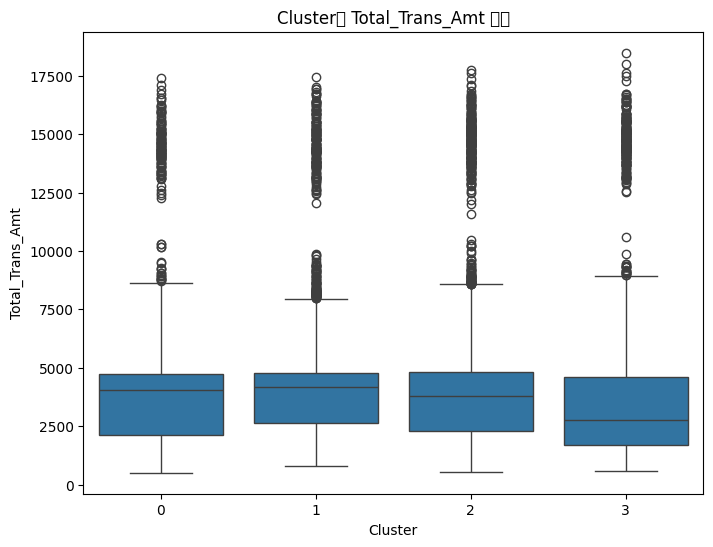

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Total_Trans_Amt', data=df_clusters)
plt.title('Cluster별 Total_Trans_Amt 분포')
plt.show()

In [22]:
df_clusters_orig = df.copy()
df_clusters_orig['Cluster'] = cluster_labels

pd.crosstab(df_clusters_orig['Card_Category'], df_clusters_orig['Cluster'], normalize='columns')
#카드 등급별은 크게 의미가 없는거 같음

Cluster,0,1,2,3
Card_Category,,,,
Blue,0.964096,0.941864,0.893844,0.926174
Gold,0.004080,0.009632,0.018548,0.013870
Platinum,0.000408,0.002752,0.002368,0.002237
Silver,0.031416,0.045752,0.085241,0.057718


In [24]:
martial = pd.crosstab(df_clusters_orig['Cluster'], df_clusters_orig['Marital_Status'], normalize='index') * 100
edu = pd.crosstab(df_clusters_orig['Cluster'], df_clusters_orig['Education_Level'], normalize='index') * 100
income = pd.crosstab(df_clusters_orig['Cluster'], df_clusters_orig['Income_Category'], normalize='index') * 100
print(martial)
print(edu)
print(income)


Marital_Status   Divorced     Married     Single    Unknown
Cluster                                                    
0                0.000000  100.000000   0.000000   0.000000
1               13.828689    0.000000  73.099415  13.071895
2               13.654301    0.039463  71.744278  14.561957
3                0.000000  100.000000   0.000000   0.000000
Education_Level    College  Doctorate   Graduate  High School  Post-Graduate  \
Cluster                                                                        
0                 9.751122   5.140759  31.742146    19.583843       5.140759   
1                10.079119   4.506364  30.684555    18.851049       4.712762   
2                 9.984215   4.538279  29.873717    20.363062       5.367009   
3                10.201342   3.534676  31.364653    20.984340       5.234899   

Education_Level  Uneducated    Unknown  
Cluster                                 
0                 13.953488  14.687882  
1                 15.617475  15.5486

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


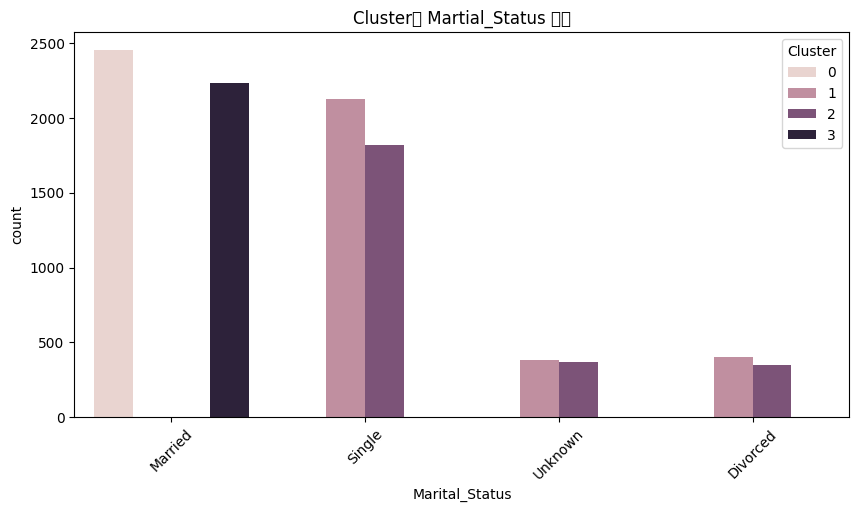

In [30]:
import seaborn as sns
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clusters_orig, x='Marital_Status', hue='Cluster')
plt.title('Cluster별 Martial_Status 분포')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


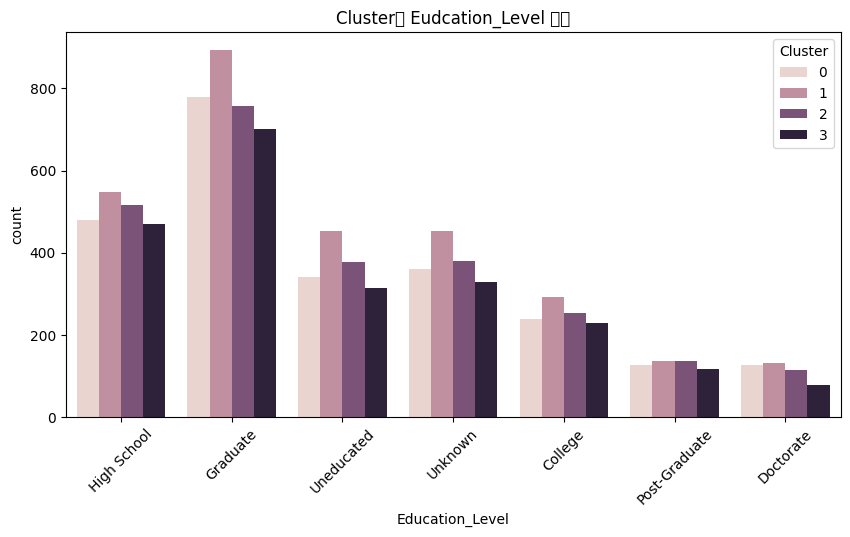

In [29]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clusters_orig, x='Education_Level', hue='Cluster')
plt.title('Cluster별 Eudcation_Level 분포')
plt.xticks(rotation=45)
plt.show()

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54252 (\N{HANGUL SYLLABLE PO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


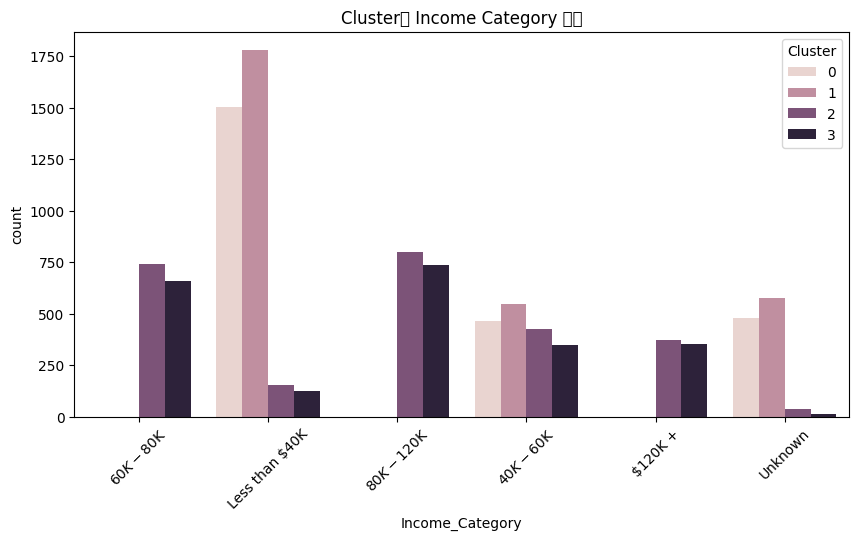

In [26]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_clusters_orig, x='Income_Category', hue='Cluster')
plt.title('Cluster별 Income Category 분포')
plt.xticks(rotation=45)
plt.show()